### Face Mask Detector - MTCNN

Face mask detection is a two-step process - first detect faces, then detect if the face is wearing a mask correctly, incorrectly, or not at all.

In this notebook we will load in a face detection model from MTCNN. We will use this model to locate all of the faces per image, and then we will use our face mask detection model to make predictions.

Multi-Task Cascaded Convolutional Neural Networks work in three steps: Proposal Network, Refine Network, and Output Network. The three tasks that an MTCNN look to accomplish are face classification (binary - is there a face, yes/no), bounding box regression, and facial landmark localization (left eye, right eye, nose, left mouth corner, right mouth corner). 

Of the three face detection models, this one is able to identify the most faces.

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd

import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model

from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import os
import glob

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
image_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/images')
annot_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/annotations/')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
labelPaths = list(sorted(os.listdir(annot_path)))

In [3]:
# Instantiate MTCNN face detector and load in mask detector model
face_detector = MTCNN(min_face_size=15)
model = load_model('face_mask_detector.h5')

In [4]:
# observe MTCNN detection output
original_image = cv2.imread(image_directories[0])
new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
detected_faces = face_detector.detect_faces(new_image)
detected_faces

[{'box': [318, 81, 41, 58],
  'confidence': 0.9989362359046936,
  'keypoints': {'left_eye': (327, 105),
   'right_eye': (348, 102),
   'nose': (339, 117),
   'mouth_left': (332, 127),
   'mouth_right': (349, 124)}},
 {'box': [77, 100, 28, 35],
  'confidence': 0.9970299005508423,
  'keypoints': {'left_eye': (87, 114),
   'right_eye': (101, 114),
   'nose': (95, 121),
   'mouth_left': (89, 130),
   'mouth_right': (100, 130)}},
 {'box': [467, 168, 22, 28],
  'confidence': 0.9577679634094238,
  'keypoints': {'left_eye': (472, 178),
   'right_eye': (481, 177),
   'nose': (475, 184),
   'mouth_left': (473, 191),
   'mouth_right': (480, 191)}}]

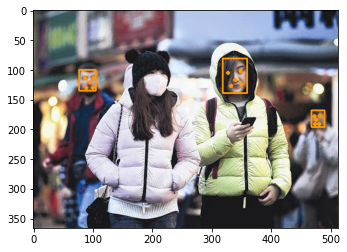

In [5]:
# Observe detections on the image
for i in range(len(detected_faces)):
    bounding_box = detected_faces[i]['box']
    keypoints = detected_faces[i]['keypoints']

    cv2.rectangle(original_image,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)

    cv2.circle(original_image,(keypoints['left_eye']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['right_eye']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['nose']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['mouth_right']), 2, (0,155,255), 2)

plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

In [6]:
detections = []

def detect(img, imageId, min_confidence):
    
    """This function uses the face detector to locate faces in an image at a given confidence minimum.
       Predictions are made using the face mask detector model. Saves image name, label info, and 
       bounding box dimensions to a list for dataframe conversion when looped over, and will 
       produce an image with predictions if run independently."""
    
    original_image = cv2.imread(img)
    new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    detected_faces = face_detector.detect_faces(new_image)
    (im_h, im_w) = original_image.shape[:2]
    
    for detected_face in detected_faces:
        confidence = detected_face['confidence']
        if confidence >= min_confidence:
            x, y, w, h = detected_face['box']
            (x, y) = (max(0, x), max(0, y))
            (x2, y2) = (min(im_w - 1, x+w), min(im_h - 1, y+h))
            face = new_image[y:y2, x:x2]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)
            face = preprocess_input(face)

            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(original_image, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(original_image, (x, y), (x2, y2), color, 2)

            detections.append([img[62:], label, color, x, y, x2,  y2])

            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.grid(None)

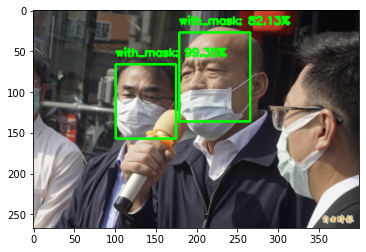

In [7]:
detections = []
for idx,image in enumerate(image_directories):

    original_image = cv2.imread(image)
    imageId = idx
    
    try:
        detect(image, imageId, 0.5)
    except:
        print(f'error with image {image}')

In [8]:
len(detections)

2670

In [9]:
detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])
detections_df.head()

,image,label,color,startX,startY,endX,endY
0,maksssksksss0.png,without_mask: 98.61%,"(0, 0, 255)",318,81,359,139
1,maksssksksss0.png,without_mask: 49.46%,"(0, 0, 255)",77,100,105,135
2,maksssksksss0.png,without_mask: 72.28%,"(0, 0, 255)",467,168,489,196
3,maksssksksss1.png,with_mask: 99.99%,"(0, 255, 0)",224,30,254,67
4,maksssksksss1.png,with_mask: 99.99%,"(0, 255, 0)",321,28,351,65


In [10]:
detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())

In [11]:
face_df = pd.read_pickle('face_df.pkl')

In [12]:
face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')

In [13]:
face_detection_count_df.columns = ['image', 'face_count', 'detected']
face_detection_count_df.fillna(0, inplace=True)
face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']

In [14]:
face_detection_count_df.sort_values('diff', ascending=False).head()

,image,face_count,detected,diff
165,maksssksksss247.png,13,3.0,10.0
170,maksssksksss251.png,24,17.0,7.0
473,maksssksksss524.png,15,9.0,6.0
259,maksssksksss331.png,12,7.0,5.0
785,maksssksksss805.png,9,4.0,5.0


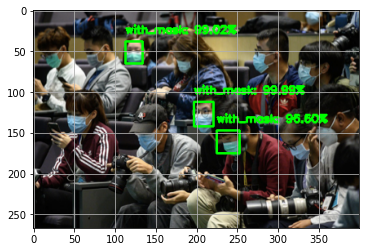

In [15]:
detect('/Users/claireph/DSI/Submissions/projects/capstone/data/images/maksssksksss247.png', 165, 0.5)

In [16]:
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()

image         maksssksksss1.pngmaksssksksss105.pngmaksssksks...
face_count                                                 1223
detected                                                    799
diff                                                        424
dtype: object

In [17]:
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()

image         maksssksksss104.pngmaksssksksss108.pngmaksssks...
face_count                                                  514
detected                                                    808
diff                                                       -294
dtype: object

In [18]:
face_detection_count_df[face_detection_count_df['diff'] == 0].sort_values(by='face_count')

,image,face_count,detected,diff
634,maksssksksss67.png,0,0.0,0.0
106,maksssksksss194.png,0,0.0,0.0
355,maksssksksss418.png,0,0.0,0.0
59,maksssksksss151.png,0,0.0,0.0
695,maksssksksss724.png,1,1.0,0.0
...,...,...,...,...
510,maksssksksss558.png,13,13.0,0.0
662,maksssksksss695.png,14,14.0,0.0
148,maksssksksss231.png,14,14.0,0.0
583,maksssksksss623.png,21,21.0,0.0
